# **Détecteur des émotions par les expressions faciales**

Un détecteur des émotions permet de détecter et d’analyser les émotions capturées à un instant t à partir d’une simple photo où une vidéo. Ce service peut identifier jusqu’à 7 émotions : la colère, le dégoût, la peur, le bonheur, neutre, la tristesse et la surprise. Vous allez construire un modèle IA qui permet de réaliser cette tâche sur des images et des vidéos.

Contexte du projet

Les expressions du visage peuvent naturellement servirent à évaluer la satisfaction d’un client aux prises avec un service après-vente ou à face à un produit récemment acquis dont il s’agit de comprendre le fonctionnement. On peut encore mentionner les applications suivantes :

    La détection d’un manque d’attention chez un conducteur en vue d’augmenter la sécurité de la conduite.
    L’évaluation du niveau de stress de passagers à l’atterrissage ou à l’arrivé en gare ou la détection de comportements suspects.
    L’humanisation des robots dans leurs interactions avec les humains dont ils prendraient en compte l’état psychique.



Modalités d'évaluation

    Un rapport sur le projet réalisé qui explique les différentes étapes du code

    Description des données

    Présentation de l'architecture utilisée

    Conclusion (avantages et inconvénients, concurrents, recommandations…)

    Revue de code avec le formateur.

  

https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html

#  projet :

- Import des librairies

- Description et analyse des données

- Création du modèle

- Compilation du modèle

- Utilisation de Haarcascade pour la prédiction

# I - Import des  librairies 

In [1]:
#importation des bibliothèques
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
import cv2
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
from sklearn.metrics import accuracy_score

# II - Description du jeu de données

Nous avons 2 répertoires de données :

    - 1 jeu de données test
    
    - 1 jeu de données d'entrainement
    
A l'intérieur de chaque répertoire, les émotions sont classées en 7 émotions ()

In [5]:
emotion = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,'sad': 4, 'surprise': 5, 'neutral': 6}

### Visualisation globale

In [6]:
#initialisation des générateurs train et test

train_dir = 'data/train'
val_dir = 'data/test'

# Cette classe effectue une génération par lots de données d'image lors du prétraitement. 
#redimensionnement : 1/255 utilisé pour normaliser la plage de valeurs RVB de 0-255 à 0-1
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

#Puisqu'il s'agit d'une classification catégorielle,  class_mode=categorical . 
#Création de sous-dossier pour chaque classe que l'on souhaite classer.

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,  
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 20091 images belonging to 7 classes.
Found 7123 images belonging to 7 classes.


Quelques précisions :

**target_size** : taille des images d'entrée, chaque image est redimensionnée à cette taille.

**batch_size**: Nombre d'images à générer par le générateur par lot.

**color_mode**: 
- si l'image est en noir et blanc ou en niveaux de gris => ``«grayscale»`` (niveaux de gris)  
- si l'image a trois canaux de couleur,=> ``«rgb»``.

**class_mode**: 
- ``«binary»`` si deux classes à prédire, sinon défini sur ``«catégorical»``, 
- au cas où il s'agit d'un système Autoencoder, l'entrée et la sortie seraient probablement la même image, dans ce cas le définir sur ``«input»``.

**shuffle**: ``True`` si on mélange l'ordre de l'image qui est produite, sinon ``False``.

**seed**: graine aléatoire pour appliquer une augmentation d'image aléatoire et mélanger l'ordre de l'image.


### Visualisation du  nombre de photos par émotion dans notre jeu de données ```train```

In [76]:
#afficher le contenu de chaque répertoire train

input_path = 'C:/Users/utilisateur/Google Drive/microsoft_ia/Google Drive/projets/ia/Reconnaissance d\'émotions/Data/train'


print(f'Nombre de photos pour chaque émotion dans les fichiers train :')

emotion={}
for emotion in os.listdir(input_path):
    path = input_path + "\\" + emotion#lettre correspond à un répertoire
    print(emotion, len(os.listdir(path)))

Nombre de photos pour chaque émotion dans les fichiers train :
angry 3069
disgust 436
fear 1642
happy 4614
neutral 4943
sad 2216
surprise 3171


### Visualisation du  nombre de photos par émotion dans notre jeu de données ```test```

In [77]:
#afficher le contenu de chaque répertoire test

input_path = 'C:/Users/utilisateur/Google Drive/microsoft_ia/Google Drive/projets/ia/Reconnaissance d\'émotions/Data/test'

print(f'Nombre de photos pour chaque émotion dans les fichiers test')

emotion={}
for emotion in os.listdir(input_path):
    path = input_path + "\\" + emotion#lettre correspond à un répertoire
    print(emotion, len(os.listdir(path)))

Nombre de photos pour chaque émotion dans les fichiers test
angry 958
disgust 111
fear 1024
happy 1719
neutral 1233
sad 1247
surprise 831


# III- Création du modèle

**<u> Les ```Convolutional Neural Network ou CNN``` : Réseaux de neurones convolutifs en français: </u>**

modèles de programmation puissants permettant notamment la reconnaissance d’images en attribuant automatiquement à chaque image fournie en entrée, une étiquette correspondant à sa classe d’appartenance.(on classe chaque image dans sa catégorie respective).

Leur mode de fonctionnement est à première vue simple : l’utilisateur fournit en entrée une image sous la forme d’une matrice de pixels.

Celle-ci dispose de 3 dimensions :

    - Deux dimensions pour une image en niveaux de gris.
    - Une troisième dimension, de profondeur 3 pour représenter les couleurs fondamentales (Rouge, Vert, Bleu).

**convolution** : La couche de convolution est le bloc de base pour construire un CNN. Il s'agit de neurones qui vont recevoir et traiter l'image par petits bouts ce qui va permettre de rétrécir progressivement la taille de l'image.

On ajoute chaque couche à notre modèle en faisant ```model.add```(la couche)

Il est important de comprendre que, là où nous voyons une image, un ordinateur ne voit qu'un tableau de chiffres. Ces chiffres sont la valeur des pixels et sont différents en fonction de la couleur et de l'intensité. Connaissant cela, nous allons pouvoir appliquer la ``convolution`` sur ces chiffres. 

Ce ne sont plus des blocs que l'on va aligner, mais ce seront des images. Nous allons aligner la valeur des pixels d'une image avec un filtre de convolution.

Au premier plan, nous avons l'image constituée de ses pixels. 
Le filtre de convolution se trouve au second plan. C'est l'image de dimension 3 par 3, 3 pixels multipliés par 3 pixels. Ce filtre est nommé aussi ``kernel``. Chaque case du filtre possède une valeur. Nous allons multiplier la valeur de chaque case du filtre par la valeur du pixel correspondant. 



**pooling**  : a pour but d'extraire les éléments saillants importants d'une image, sans se préoccuper des détails. Nous savons qu'une image est constituée de pixels. Comme pour l'opération de convolution, le pooling est effectué à l'aide d'une fenêtre glissante que l'on applique sur une image. Cette fenêtre délimitant la zone de calcul, est nommée « fenêtre de pooling ». La fenêtre de pooling réalise une opération élémentaire. Elle extrait la plus grande valeur de la zone analysée, ensuite, on glisse la fenêtre de pooling vers la droite, et on renouvelle l'opération. Ainsi de suite, jusqu'à traiter toute l'image.  Ici nous patons sur le max pooling. 

Le **dropout** consiste à éteindre des neurones ainsi que toutes leurs connexions. Cette opération dropout n'est effectuée que durant l'apprentissage. Quel est l'intérêt du dropout ? Au cours de l'apprentissage, le dropout évite aux neurones de se surspécialiser. Le dropout est un défi lancé au réseau à convolution durant l'apprentissage. Le dropout force le réseau à apprendre correctement et évite que quelques neurones ne prédominent

In [5]:
# Create the model
model = Sequential()

# 1ère couche de convolution :
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 2ème couche de convolution 
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#Ecrasement de l'input pour qu'il soit d'une seule dimension
model.add(Flatten())
# Passage aux couches dense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# IV - Compilation du modèle

## test 1  : avec 10 epochs

In [6]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
epochs = 10
history = model.fit(train_generator, batch_size=64, epochs=epochs, validation_data=(validation_generator))

Epoch 1/10
314/314 [==============================] - 235s 745ms/step - loss: 1.7925 - accuracy: 0.2652 - val_loss: 1.7106 - val_accuracy: 0.3021
Epoch 2/10
314/314 [==============================] - 222s 708ms/step - loss: 1.5345 - accuracy: 0.4308 - val_loss: 1.4202 - val_accuracy: 0.4551
Epoch 3/10
314/314 [==============================] - 242s 770ms/step - loss: 1.2893 - accuracy: 0.5325 - val_loss: 1.3071 - val_accuracy: 0.4940
Epoch 4/10
314/314 [==============================] - 251s 800ms/step - loss: 1.2011 - accuracy: 0.5641 - val_loss: 1.3019 - val_accuracy: 0.4956
Epoch 5/10
314/314 [==============================] - 266s 846ms/step - loss: 1.1242 - accuracy: 0.5929 - val_loss: 1.2282 - val_accuracy: 0.5239
Epoch 6/10
314/314 [==============================] - 235s 746ms/step - loss: 1.0797 - accuracy: 0.6066 - val_loss: 1.1904 - val_accuracy: 0.5451
Epoch 7/10
314/314 [==============================] - 243s 775ms/step - loss: 1.0158 - accuracy: 0.6310 - val_loss: 1.1908 -

modele non performant

## test 2 :  avec 50 epochs

In [ ]:
#nombre de photos dans le train
num_train = 20091
#nombre de photos dans le test
num_val = 7123
#Nombre d'images à générer par le générateur par lot.
batch_size = 64
#nombre de tour d'apprentissage
num_epoch = 50

In [16]:
# tracer les courbes de précision et de perte
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # résumer l'historique pour plus de précision (accuracy)
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # résumer l'historique pour plus de la perte (loss)
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

# Compilation et sauvegarde du modèle

Lorsque le modèle est crée, on indique que l'on ne souhaite plus toucher à son architecture via la méthode ```compile``` et les 3 paramètres  : ```loss, optimizer et metric```.

**Loss** : correspond à la fonction coût, c'est l'erreur de notre modèle. Plus il prédit la bonne émotion par rapport à l'image qu'il reçoit, plus le loss sera faible. 
L'objetif de l'apprentissage d'un modèle est de minimiser la fonction coût.

Pour ce paramètre, on va choisir ``categorical_crossentropy``car on a plusieurs labels ("catégories") et nous souhaitons que le modèle attribue le score de probabilité le plus élevé possible au bon label.(pour 2 catégories, nous aurions utilisé ``binaire``)

**Optimizer** : l'optimiseur est une implémentation d'un algorithme d'apprentissage. Nous allons utiliser ``Adam``, un algorithme dit de descente de gradient. Il faut comprendre que l'on va descendre la courbe de la fonction coût/loss en approchant le réglage optimal pour chaque paramètre de nos neurones. Le réglage optimal est celui où la dérivée de la fonction coût par rapport aux paramètres est nulle, c'est son point le plus bas :
    
**metrics**: on va suivre un métrique de précision afin d'avoir une visibilité sur les performances de notre modèle à chaque tour d'apprentissage. 

Epoch 1/50
313/313 [==============================] - 206s 656ms/step - loss: 0.3418 - accuracy: 0.8804 - val_loss: 1.3674 - val_accuracy: 0.6030
Epoch 2/50
313/313 [==============================] - 206s 658ms/step - loss: 0.3369 - accuracy: 0.8796 - val_loss: 1.3994 - val_accuracy: 0.5970
Epoch 3/50
313/313 [==============================] - 204s 650ms/step - loss: 0.3222 - accuracy: 0.8884 - val_loss: 1.3932 - val_accuracy: 0.6030
Epoch 4/50
313/313 [==============================] - 205s 654ms/step - loss: 0.3238 - accuracy: 0.8869 - val_loss: 1.4200 - val_accuracy: 0.5988
Epoch 5/50
313/313 [==============================] - 203s 648ms/step - loss: 0.3215 - accuracy: 0.8877 - val_loss: 1.4211 - val_accuracy: 0.6008
Epoch 6/50
313/313 [==============================] - 206s 658ms/step - loss: 0.3137 - accuracy: 0.8875 - val_loss: 1.4011 - val_accuracy: 0.5976
Epoch 7/50
313/313 [==============================] - 208s 665ms/step - loss: 0.3075 - accuracy: 0.8916 - val_loss: 1.4126 -

<ipython-input-15-e3d78e701c3b>:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-15-e3d78e701c3b>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


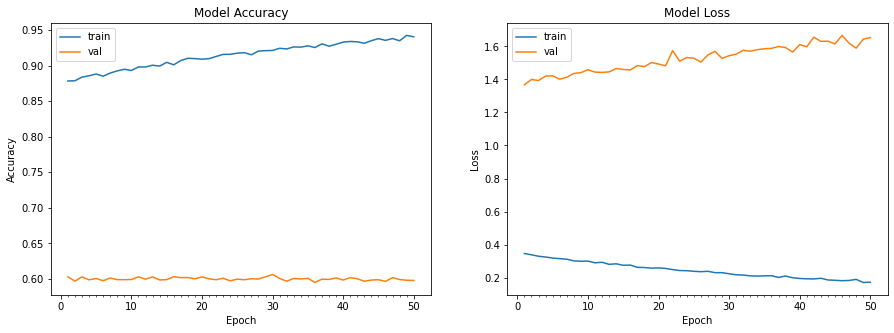

In [16]:
#compilation du modèle
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])

model_info = model.fit_generator(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=num_val // batch_size)

#affichage
plot_model_history(model_info)

#sauvegarde du model
model.save('model.h5')



# Architecture du modèle

Le ```Param #``` => "poids" des neurones est le paramètres que l'on va affiner à chaque tour d'apprentissage de notre modèle et il ne concerne que les couches de neurones. Les autres couches ne sont pas concernées.

Notre modèle sequential a 4 couches de convolution 2D et 2 couches denses, output compris. 

La dernière couche Dense, appelée l'output, a 7 neurones de sortie, 1 pour chaque émotion.


In [55]:
model = load_model('model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         1

# V-  Utilisation de Haarcascade pour la prédiction

Un Haar Cascade est fondamentalement un classificateur utilisé pour détecter l'objet pour lequel il a été formé.

Pour créer un classificateur Haar Cascade, on a besoin d'images "positives" et d'images "négatives". 

Les images "positives"  sont des images contenant principalement l'objet que vous voulez trouver. Cela peut être soit des images contenant principalement l'objet, soit des images contenant l'objet seul, et on doit spécifier la région d'intérêt (ROI) ou se trouve l'objet. 

Les images "négatives"  peuvent être n'importe quoi  et sont des images d'arrière-plan qui ne contiennent pas l'objet qu'on recherche. Avec ces éléments positifs, nous construisons un fichier vectoriel qui regroupe tous ces éléments "positifs". Une bonne chose à propos des images positives est que vous pouvez en réalité avoir une seule image de l'objet que vous souhaitez détecter, puis des milliers d'images négatives et créer des milliers d'images positives.


OpenCV est livré avec un entraîneur ainsi qu'un détecteur. Si vous voulez former votre propre classificateur pour n'importe quel objet comme une voiture, des avions, etc., vous pouvez utiliser OpenCV pour en créer un. 

Nous traiterons ici de la détection. Nous allons charger les classificateurs XML requis ``haarcascade_frontalface_default.xml``.


In [44]:
# emotions will be displayed on your face from the webcam feed
model = load_model('model.h5')

# prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)

# dictionary which assigns each label an emotion (alphabetical order)
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# start the webcam feed
cap = cv2.VideoCapture(0)
while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        print(maxindex)
        cv2.putText(frame, emotion_dict[maxindex], (x, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        if maxindex == 0:
            image = cv2.imread("images/Angry.jpg")
            cv2.imshow('emojie', image)
            cv2.putText(frame, "Pourquoi es-tu en colère?", (x, y+200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        elif maxindex == 1:
            image = cv2.imread("images/Disgusted.jpg")
            cv2.imshow('emojie', image)
            cv2.putText(frame, "Pourquoi es-tu dégouté(e)", (x, y+200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        elif maxindex == 2:
            image = cv2.imread("images/Fearful.jpg")
            cv2.imshow('emojie', image)
            cv2.putText(frame, "Pourquoi as-tu peur?", (x, y+200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        elif maxindex == 3:
            image = cv2.imread("images/Happy.jpg")
            cv2.imshow('emojie', image)
            cv2.putText(frame, "Happy? yes!", (x, y+200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        elif maxindex == 4:
            image = cv2.imread("images/Neutral.jpg")
            cv2.imshow('emojie', image)
            cv2.putText(frame, "Es-tu vivant?", (x, y+200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        elif maxindex == 5:
            image = cv2.imread("images/Sad.jpg")
            cv2.imshow('emojie', image)
            cv2.putText(frame, "Pourquoi es-tu triste?", (x, y+200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        elif maxindex == 6:
            image = cv2.imread("images/Surprised.jpg")
            cv2.imshow('emojie', image)
            cv2.putText(frame, "Pourquoi es-tu surpris(e)?", (x, y+200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.imshow('Video', cv2.resize(frame,(960,720),interpolation = cv2.INTER_CUBIC))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

4
4
3
6
0
0
3
6
6
4
6
6
6
6
4
1
4
6
4
4
4
3
5
2
3
3
3
4
3
4
3
4
3
3
4
4
3
3
3
3
3
3
3
3
4
3
3
3
3
4
3
3
3
3
3
4
3
3
3
4
3
3
3
4
3
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
4
3
3
4
4
3
4
3
4
3
4
6
4
3
4
3
3
3
3
4
4
4
3
4
3
4
4
4
4
3
3
3
4
3
3
4
3
3
3
3
3
3
4
3
3
3
4
4
3
3
3
4
3
3
3
3
3
5
3
4
3
4
3
3
4
4
4
4
4
4
3
3
3
3
3
4
4
4
4
4
4
4
4
3
4
4
3
3
3
5
3
3
3
3
3
6
3
3
3
4
3
3
4
4
3
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
4
3
3
4
4
3
3
4
3
3
4
2
2
4
3
3
3
5
3
3
3
3
0
5
4
3
3
4
3
4
3
3
3
3
3
3
3
3
4
3
3
3
3
3
4
6
4
4
2
4
4
4
4
4
4
4
4
0
4
4
4
5
6
6
6
6
4
4
6
6
6
6
6
6
4
6
6
3
6
6
5
4
4
4
4
4
6
4
4
6
4
6
6
6
6
6
6
6
6
6
6
4
3
4
4
4
3
3
3
3
3
5
3
3
3
3
6
6
6
0
6
0
0
0
6
6
4
6
6
0
0
6
0
6
6
0
6
6
4
6
6
6
6
6
6
6
6
6
4
6
6
6
6
6
6
6
6
6
6
6
6
4
6
6
3
3
6
3
6
4
4
4
4
4
4
6
4
4
4
4
4
4
4
4
4
4
4
4
6
6
4
6
4
4
4
4
4
4
4
4
6
6
6
6
6
6
4
4
4
4
4
4
4
4
4
4
4
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


KeyboardInterrupt: 

# Autres technologies utilisées non sélectionnées pour l'étude 

# Interface graphique du classificateur des émotions

Nous allons maintenant créer une interface utilisateur graphique pour notre classificateur de panneaux de signalisation avec Tkinter. Tkinter est une boîte à outils d'interface graphique dans la bibliothèque python standard.

Dans ce fichier, nous avons d’abord chargé le modèle entraîné ‘traffic_classifier.h5’ à l’aide de Keras.

Et puis nous construisons l'interface graphique pour télécharger l'image et un bouton est utilisé pour classifier qui appelle la fonction classify (). 
La fonction classify () convertit l'image en dimension de forme (1, 30, 30, 3). 
En effet, pour prédire le panneau de signalisation, nous devons fournir la même dimension que nous avons utilisée lors de la construction du modèle. 
Ensuite, nous prédisons la classe, le model.predict_classes (image) nous renvoie un nombre c qui représente la classe à laquelle il appartient. Nous utilisons le dictionnaire pour obtenir les informations sur la classe.

In [62]:
# Import des librairies
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy

In [63]:
#Charger notre fichier
from keras.models import load_model
model = load_model('model.h5')

In [64]:
#détail des classes
classes = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}


In [65]:
#initialisation tkinter
top=tk.Tk()
top.geometry('800x600')
top.title('Classification des emotions')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)

In [66]:
#convertion de l'image en dimension de forme (1, 30, 30, 3) aux mêmes dimensions que notre modèle
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = image.resize((30,30))
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    pred = model.predict_classes([image])[0]
    sign = classes[pred+1]
    print(sign)
    label.configure(foreground='#011638', text=sign) 

In [67]:
#bouton pour classifier et utiliser la fonction précédente
def show_classify_button(file_path):
    classify_b=Button(top,text="Classification image",command=lambda: classify(file_path),padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)


In [68]:
def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),(top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass


In [69]:
upload=Button(top,text="Télécharger image",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))

In [70]:
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Connaitre émotions",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\utilisateur\anaconda3\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "<ipython-input-67-9eec747d558d>", line 3, in <lambda>
    classify_b=Button(top,text="Classification image",command=lambda: classify(file_path),padx=10,pady=5)
  File "<ipython-input-66-e14ad89b9f07>", line 8, in classify
    pred = model.predict_classes([image])[0]
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py", line 459, in predict_classes
    proba = self.predict(x, batch_size=batch_size, verbose=verbose)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1629, in predict
    tmp_batch_outputs = self.predict_function(iterator)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  F

In [47]:
# emotions will be displayed on your face from the webcam feed
model = load_model('model.h5')

# prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)

# dictionary which assigns each label an emotion (alphabetical order)
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# start the webcam feed
cap = cv2.VideoCapture(0)
while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    print(emotion_dict[maxindex])
    #Chargement d'une image
    image = cv2.imread("emo/"+emotion_dict[maxindex]+".jpg")
    image = cv2.resize(image, (35,35))
    cv2.imshow('emo', image)
            

    
    cv2.imshow('Video', cv2.resize(frame,(960,720),interpolation = cv2.INTER_CUBIC))
    #pour sauvegarder une image
    #cv2.imwrite(x.png)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
#permet de libérer la mémoire une fois la fenêtre fermée
cv2.destroyAllWindows()

Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Sad
Neutral
Neutral
Neutral
Neutral
Neutral
Sad
Sad
Neutral
Neutral
Neutral
Sad
Sad
Sad
Surprised


error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


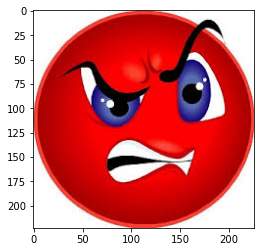

In [28]:
# emotions will be displayed on your face from the webcam feed
#model = load_model('model.h5')


#detec_visage_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

img = cv2.imread("emo/angry.jpg", 3)
#transformer une image de couleur en gris
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

visage = detec_visage_model.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in visage:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)









In [ ]:
Nous avons notre model qui fonctionne notamment grâce au fichier "haarcascade_frontalface_default.xml" cf le github 


In [1]:
import cv2
#lecture de l'image
img = cv2.imread("emo/angry.jpg", 3)
#NamedWindow pour afficher l'image
cv2.namedWindow("image", cv2.WINDOW_NORMAL)
cv2.imshow('image',img)
#met en attente la fenetre
cv2.waitKey(0)
#permet de libérer la mémoire une fois la fenêtre fermée
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
#lecture de l'image
img = cv2.imread("emo/angry.jpg", 3)
#transformer une image de couleur en gris
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret,th=cv2.threshold(gray,150,255,cv2.THRESH_BINARY)
#NamedWindow pour afficher l'image
cv2.namedWindow("image", cv2.WINDOW_NORMAL)
cv2.imshow('image',th)
#met en attente la fenetre
cv2.waitKey(0)
#permet de libérer la mémoire une fois la fenêtre fermée
cv2.destroyAllWindows()